In [1]:
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats
from collections import Counter
from wordcloud import WordCloud
from pandas import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk


# EDA para possibilitar a Classificação

Carregando os dados

In [2]:
import pandas as pd
def load_data(file_path):
    return pd.read_parquet(file_path)

products_file = 'data/olist_products_dataset.parquet'
orders_file = 'data/olist_orders_dataset.parquet'
order_items_file = 'data/olist_order_items_dataset.parquet'
customers_file = 'data/olist_customers_dataset.parquet'
geolocation_file = 'data/olist_geolocation_dataset.parquet'
payments_file = 'data/olist_order_payments_dataset.parquet'
reviews_file = 'data/olist_order_reviews_dataset.parquet'
sellers_file = 'data/olist_sellers_dataset.parquet'
category_file = 'data/product_category_name_translation.parquet'

products_df = load_data(products_file)
orders_df = load_data(orders_file)
order_items_df = load_data(order_items_file)
customers_df = load_data(customers_file)
geolocation_df = load_data(geolocation_file)
payments_df = load_data(payments_file)
reviews_df = load_data(reviews_file)
sellers_df = load_data(sellers_file)
category_df = load_data(category_file)

# Merge dos dataframes
orders_products = orders_df.merge(order_items_df, on='order_id', how='inner')
orders_products_customers = orders_products.merge(customers_df, on='customer_id', how='inner')
orders_products_customers_reviews = orders_products_customers.merge(reviews_df, on='order_id', how='inner')
orders_products_customers_reviews_payments = orders_products_customers_reviews.merge(payments_df, on='order_id', how='inner')
orders_products_customers_reviews_payments_sellers = orders_products_customers_reviews_payments.merge(sellers_df, on='seller_id', how='inner')
all_data = orders_products_customers_reviews_payments_sellers.merge(products_df, on='product_id', how='inner')
all_data = all_data.merge(category_df, on='product_category_name', how='inner')

# Remover as duplicatas
all_data = all_data.drop_duplicates()

# Removando as reviews vazias
all_data = all_data.dropna(subset=['review_comment_message'])

In [3]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

In [4]:
datetime_columns = ['order_purchase_timestamp', 'order_approved_at',
                    'order_delivered_carrier_date', 'order_delivered_customer_date',
                    'order_estimated_delivery_date',
                    'review_creation_date', 'review_answer_timestamp',
                    'shipping_limit_date']
all_data[datetime_columns] = all_data[datetime_columns].apply(pd.to_datetime)

In [5]:
all_data = all_data.rename(columns={'product_name_lenght': 'product_name_length',
                                   'product_description_lenght': 'product_description_length'
                                  })

In [6]:
df_summary(all_data)

Dataset Shape: (48906, 40)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,39714,e481f51cbdc54678b7cc49136f2d6af7,15.12
1,customer_id,object,0,39714,9ef432eb6251297304e76186b10a928d,15.12
2,order_status,object,0,6,delivered,0.26
3,order_purchase_timestamp,datetime64[ns],0,39598,2017-10-02 10:56:33,15.12
4,order_approved_at,datetime64[ns],8,38196,2017-10-02 11:07:15,15.05
5,order_delivered_carrier_date,datetime64[ns],796,35470,2017-10-04 19:55:00,14.90
6,order_delivered_customer_date,datetime64[ns],1539,38251,2017-10-10 21:25:13,15.07
7,order_estimated_delivery_date,datetime64[ns],0,437,2017-10-18 00:00:00,8.47
8,order_item_id,int64,0,21,1,0.83
9,product_id,object,0,18575,87285b34884572647811a353c7ac498a,13.15


#### Utilizando a métrica do compound score do VADER para agregar na classificação

In [7]:
analyzer = SentimentIntensityAnalyzer()
all_data['comp_score'] = all_data['review_comment_message'].apply(lambda review: analyzer.polarity_scores(str(review))['compound'] if not pd.isna(review) else None)

In [8]:
all_data[['review_comment_message','comp_score']].head(50)

,review_comment_message,comp_score
0,"Não testei o produto ainda, mas ele veio corre...",0.0000
1,"Não testei o produto ainda, mas ele veio corre...",0.0000
2,"Não testei o produto ainda, mas ele veio corre...",0.0000
3,Deveriam embalar melhor o produto. A caixa vei...,0.0000
4,"Só achei ela pequena pra seis xícaras ,mais é ...",0.0000
6,Prezados que porcaria de atendimento ao client...,0.0000
11,Veio no prazo combinado super bem embalado.,0.4019
18,Produto lindo entrega super rápida,0.5994
20,muito bom,0.0000
23,Chegou intacto. O porta escova não tem como vc...,0.0000


### Tratando os dados em texto antes de ir para o feature engineering

In [9]:
all_data[['review_comment_message']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 48906 entries, 0 to 115608
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_comment_message  48906 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [10]:
# retirando os comentários e deixando apenas os fatores relacionados aos grupos de palavras
review_comment_message_dropna = all_data['review_comment_message'].dropna()
review_comment_message_dropna

,review_comment_message
0,"Não testei o produto ainda, mas ele veio corre..."
1,"Não testei o produto ainda, mas ele veio corre..."
2,"Não testei o produto ainda, mas ele veio corre..."
3,Deveriam embalar melhor o produto. A caixa vei...
4,"Só achei ela pequena pra seis xícaras ,mais é ..."
...,...
115599,faltou a forma e nao consigo entrar em contato...
115605,Recomendo
115606,Recomendo
115607,Recebi corretamente o produto no prazo estipul...


In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importando as stopwords em português

In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Tokenizando uma dada string
def tokenize_content(content):
  words = [word.lower() for word in nltk.word_tokenize(content) if word.isalpha()]
  words = [word for word in words if word not in stopwords_pt]
  return words

In [14]:
reviews = review_comment_message_dropna.tolist()
top_tokens_list = []

# Criando top_tokens_list pra todas as palavras nas reviews
for review in reviews:
  token_words = tokenize_content(review)
  top_tokens_list.append(token_words)

top_tokens = [item for sublist in top_tokens_list for item in sublist]

##### Contabilizando as palavras que mais aparecem

In [15]:
cnt = Counter()

for word in top_tokens:
  cnt[word] += 1

top_most_common = sorted(cnt.items(), key=lambda item: -item[1])[:100]

##### Nuvem de palavras com a frequência delas

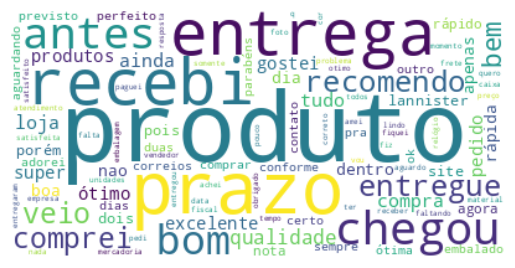

In [16]:
span_freq_dict = {}

# Creat top most common words dict with frequencies
for i in top_most_common:
  # Ignore the word if it is in stopwords in english
  span_freq_dict[i[0]] = i[1]

wc = WordCloud(background_color='white')
wc.generate_from_frequencies(span_freq_dict)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Engineering

*Resolvendo o desequilíbrio do número de notas 5, atribuindo as notas de 1 a 5 em 3 grupos*

In [17]:
print("review_score == 5: %d" % len(all_data[all_data['review_score']==5]))
print("review_score == 4: %d" % len(all_data[all_data['review_score']==4]))
print("review_score == 3: %d" % len(all_data[all_data['review_score']==3]))
print("review_score == 2: %d" % len(all_data[all_data['review_score']==2]))
print("review_score == 1: %d" % len(all_data[all_data['review_score']==1]))
score_list = [len(all_data[all_data['review_score']==1]),
              len(all_data[all_data['review_score']==2]),
              len(all_data[all_data['review_score']==3]),
              len(all_data[all_data['review_score']==4]),
              len(all_data[all_data['review_score']==5])]

review_score == 5: 23330
review_score == 4: 6979
review_score == 3: 4444
review_score == 2: 2839
review_score == 1: 11314


In [18]:
# Clonando `all_data` no `feature_df` pra ser usado na modelagem depois
feature_df = all_data

# Atribuindo as notas aos 3 grupos com a `review_score`
feature_df.loc[feature_df['review_score'] == 5, "review_score_factor"] = 2
feature_df.loc[feature_df['review_score'] <= 4, "review_score_factor"] = 1
feature_df.loc[feature_df['review_score'] <= 2, "review_score_factor"] = 0

In [19]:
feature_df['review_score_factor']

,review_score_factor
0,1.0
1,1.0
2,1.0
3,1.0
4,2.0
...,...
115599,0.0
115605,2.0
115606,2.0
115607,2.0


### Categorizando o preço total e o frete

price_factor (0 se o price < 50º percentil, a mediana e 1 se o price for >= ao 50º percentil)

freight_value_factor (0 se o freight_value < 50º percentil, a mediana e 1 se o freight_value for >= ao 50º percentil)

In [20]:
price_median = feature_df['price'].median();
feature_df.loc[feature_df['price'] >= price_median, "price_factor"] = 1
feature_df.loc[feature_df['price'] < price_median, "price_factor"] = 0

freight_value_median = feature_df['freight_value'].median();
feature_df.loc[feature_df['freight_value'] >= freight_value_median, "freight_value_factor"] = 1
feature_df.loc[feature_df['freight_value'] < freight_value_median, "freight_value_factor"] = 0

### Categorizando se o pacote foi entregue ou não

In [21]:
feature_df.loc[feature_df['order_status'] == 'delivered', "if_delivered"] = 1
feature_df.loc[feature_df['order_status'] != 'delivered', "if_delivered"] = 0

### Diferença entre data atual e estimada de entrega

In [22]:
# Checando quantas linhas no non_delivered não possuem dados no `order_delivered_customer_date`
non_delivered = feature_df[feature_df['if_delivered'] == 0]
nan_delivered_customer_count = non_delivered[non_delivered['order_delivered_customer_date'].isnull()]['order_id'].count()
print(f'There are {nan_delivered_customer_count} rows isnull in order_delivered_customer_date column for all non_delivered rows')

There are 1534 rows isnull in order_delivered_customer_date column for all non_delivered rows


In [23]:
# Convertendo colunas para objetos datetime antes de fazer a diferença/subtração
feature_df['order_estimated_delivery_date'] = pd.to_datetime(feature_df['order_estimated_delivery_date'])
feature_df['order_delivered_customer_date'] = pd.to_datetime(feature_df['order_delivered_customer_date'])

# Mantendo a diferença em dias na coluna feature_df
feature_df['actual_est_delivery_diff'] = (feature_df['order_estimated_delivery_date'] - feature_df['order_delivered_customer_date']).dt.days

### Quanto tempo demorou pra receber a entrega

In [24]:
# Convert 'order_purchase_timestamp' to datetime objects
feature_df['order_purchase_timestamp'] = pd.to_datetime(feature_df['order_purchase_timestamp'])

# Cálculo do tempo de entrega
feature_df['delivery_duration'] = (feature_df['order_delivered_customer_date'] - feature_df['order_purchase_timestamp']).dt.days

### Limpando informações de produtos que estão vazias

In [25]:
feature_df.loc[feature_df['product_photos_qty'].isnull(), "product_photos_qty"] = 0
feature_df.loc[feature_df['product_description_length'].isnull(), "product_description_length"] = 0
feature_df = feature_df.dropna(subset=['product_weight_g'])

In [2]:
#feature_df.head()

NameError: name 'feature_df' is not defined

In [27]:
feature_df[['review_comment_message','comp_score']].sort_values(by='comp_score', ascending=False)

,review_comment_message,comp_score
96765,Amo comprar nessa conceituada empresa...spr re...,0.9909
38701,Recebi dia 10-10 .veio tudo perfeito! Amei o p...,0.9792
96933,😁😁😁😁😁🤗🤗🤗🤗🏇👏👏👏👏👏👏,0.9756
96326,Amo comprar nas lojas lannister. parabéns esto...,0.9660
98815,Muito bom entregou até antes do dia 😆😆😆😆😆😆😆😆,0.9517
...,...,...
35156,"Infelizmente não recebi o produto, comprei com...",-0.8885
22910,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039
19667,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039
19666,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039


In [ ]:
# feature_df.to_parquet('data/feature_df.parquet')